In [13]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

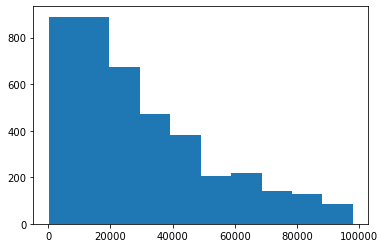

In [14]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

#setup y
y_cols = ['Ever Enrolled Count','DP03_0095E'] #just predict mkt share
    
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys: 
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

X = X/X.var()

#add a categorical value for large vs small mkts
cutoff = 1e5
plt.hist(df['DP03_0095E'][df['DP03_0095E'] < 1e5] )
X['large_mkt'] = 1*(df['DP03_0095E'] > 1e5)

In [15]:
training_test = []
num_trials = 5
for i in range(num_trials):
    test_size = 0.33
    np.random.seed()
    X_train, X_test, share_train, share_test = train_test_split(sm.add_constant(X), y, test_size=test_size)
    y_train = (share_train['Ever Enrolled Count']/share_train['DP03_0095E']).to_frame()
    training_test.append( (X_train, X_test, share_train, share_test, y_train) )

In [16]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,share_test):
    #setup the data
    share_test = np.array(share_test)
    y_pred = y_pred.flatten()*share_test[:,1]
    y_test = share_test[:,0]
    
    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

def get_mse(y_pred,share_test):
    share_test = np.array(share_test)
    #ever enrolled count is column 0... want to weight mse by mkt size
    return (y_pred*share_test[:,1] - share_test[:,0])**2


def plot_importance(X_test,model,v=False):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()
    if v:
        print(importance['features'].head(20))

In [17]:
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(20)

    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

1.6175614228543609
2.4736741602635455
1.1770770745470711
3.6066098962099193
2.7880761503802343


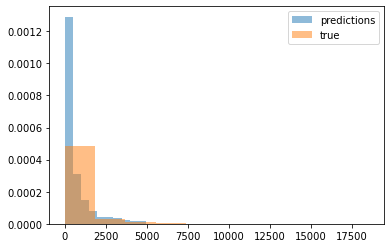

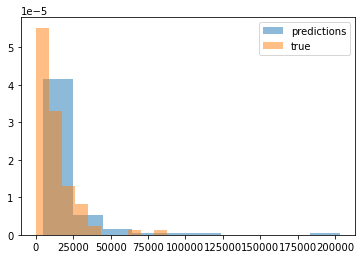

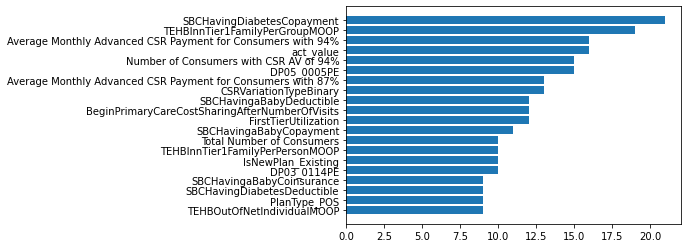

37                            SBCHavingDiabetesCopayment
40                        TEHBInnTier1FamilyPerGroupMOOP
208    Average Monthly Advanced CSR Payment for Consu...
46                                             act_value
205               Number of Consumers with CSR AV of 94%
153                                          DP05_0005PE
207    Average Monthly Advanced CSR Payment for Consu...
3                                 CSRVariationTypeBinary
34                              SBCHavingaBabyDeductible
1         BeginPrimaryCareCostSharingAfterNumberOfVisits
0                                   FirstTierUtilization
43                               SBCHavingaBabyCopayment
202                            Total Number of Consumers
47                       TEHBInnTier1FamilyPerPersonMOOP
8                                     IsNewPlan_Existing
132                                          DP03_0114PE
45                             SBCHavingaBabyCoinsurance
36                           SB

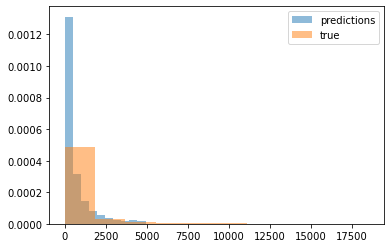

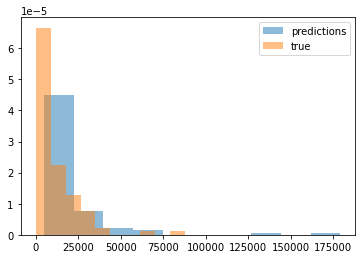

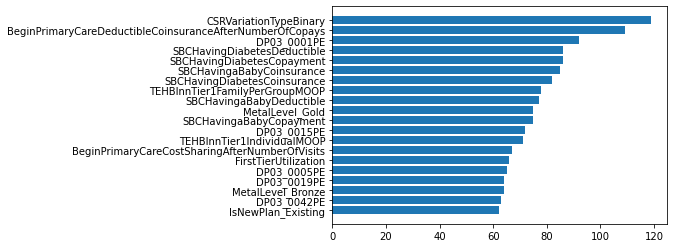

3                                CSRVariationTypeBinary
2     BeginPrimaryCareDeductibleCoinsuranceAfterNumb...
59                                          DP03_0001PE
44                          SBCHavingDiabetesDeductible
45                           SBCHavingDiabetesCopayment
55                            SBCHavingaBabyCoinsurance
50                         SBCHavingDiabetesCoinsurance
48                       TEHBInnTier1FamilyPerGroupMOOP
42                             SBCHavingaBabyDeductible
19                                      MetalLevel_Gold
52                              SBCHavingaBabyCopayment
73                                          DP03_0015PE
43                           TEHBInnTier1IndividualMOOP
1        BeginPrimaryCareCostSharingAfterNumberOfVisits
0                                  FirstTierUtilization
63                                          DP03_0005PE
77                                          DP03_0019PE
17                                    MetalLevel

In [18]:
params = [(2,.5,.9,.9),(5,.5, 0.5, .9)]

for param in params:
    mses = []
    r2s = []
    for i in range(num_trials):
        X_train, X_test, share_train, share_test, y_train = training_test[i]
        model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                             eta=param[1], subsample=param[2], colsample_bytree=param[3])
        model.fit(X_train, y_train)

        y_pred = get_predictions(model,X_test)

        mse = float( get_mse(y_pred,share_test).mean() )
        r2 = float( 1 - mse/share_test['Ever Enrolled Count'].var() ) 
        print( 1 - r2 )
        mses.append(mse)
        r2s.append(r2)
        
        if i == num_trials -1:
            #plot the difference between true and predicted
            split = 5000
            plot_prediction(split,y_pred,share_test)
            plot_importance(X_test,model,v=True)
            
    print( np.array(mses).mean() , np.array(r2s).mean()  )
    print( np.median(mses) , np.median(r2s)  )

0.875353889389597
0.960721497876068
0.8007536046765902
1.248207458120383
0.9479664003612763


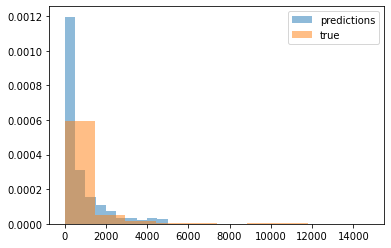

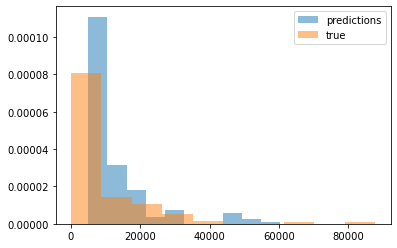

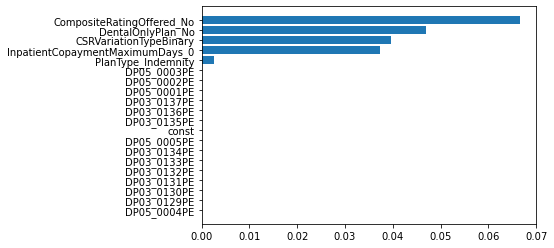

DP05_0004PE                        0.000000
DP03_0129PE                        0.000000
DP03_0130PE                        0.000000
DP03_0131PE                        0.000000
DP03_0132PE                        0.000000
DP03_0133PE                        0.000000
DP03_0134PE                        0.000000
DP05_0005PE                        0.000000
const                              0.000000
DP03_0135PE                        0.000000
DP03_0136PE                        0.000000
DP03_0137PE                        0.000000
DP05_0001PE                        0.000000
DP05_0002PE                        0.000000
DP05_0003PE                        0.000000
PlanType_Indemnity                 0.002641
InpatientCopaymentMaximumDays_0    0.037396
CSRVariationTypeBinary             0.039587
DentalOnlyPlan_No                  0.046967
CompositeRatingOffered_No          0.066727
Name: score, dtype: float64
alpha_value: 100
26975944.596593875 0.03339942991521709
17065255.62541849 0.0520335996387236

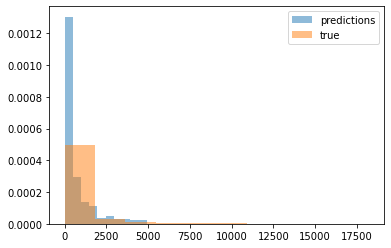

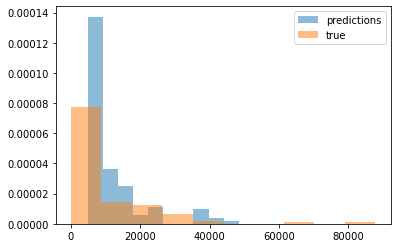

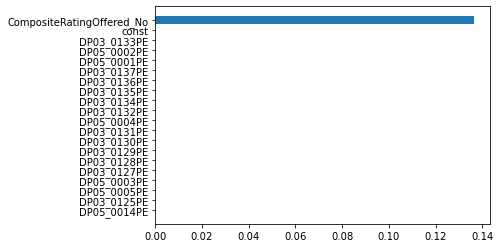

DP05_0014PE                  0.000000
DP03_0125PE                  0.000000
DP05_0005PE                  0.000000
DP05_0003PE                  0.000000
DP03_0127PE                  0.000000
DP03_0128PE                  0.000000
DP03_0129PE                  0.000000
DP03_0130PE                  0.000000
DP03_0131PE                  0.000000
DP05_0004PE                  0.000000
DP03_0132PE                  0.000000
DP03_0134PE                  0.000000
DP03_0135PE                  0.000000
DP03_0136PE                  0.000000
DP03_0137PE                  0.000000
DP05_0001PE                  0.000000
DP05_0002PE                  0.000000
DP03_0133PE                  0.000000
const                        0.000000
CompositeRatingOffered_No    0.136526
Name: score, dtype: float64
alpha_value: 250
24427026.845021132 0.18129181655010257
13824675.481414154 0.20837780153812224


In [20]:
# Vary alpha values
a = [100,250]

for i in a: 
    mses = []
    r2s = []
    for j in range(num_trials):
        X_train, X_test, share_train, share_test, y_train = training_test[j]
        lasso = sm.OLS(1000*y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
        y_pred = get_predictions(lasso,X_test/1000)
        
        mse = float( get_mse(y_pred,share_test).mean() )
        r2 = float( 1 - mse/share_test['Ever Enrolled Count'].var() ) 
        print( 1 - r2 )
        mses.append(mse)
        r2s.append(r2)
        
        if j == num_trials -1:
            #plot the difference between true and predicted
            split = 5000
            plot_prediction(split,y_pred,share_test)

            #also plot important feature
            param_df = pd.DataFrame(np.abs(lasso.params),
                                    columns=['score']).sort_values(by=['score'], ascending=False).head(20)
            param_df['features'] = param_df.index
            plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
            plt.show()
            print(param_df['score'].iloc[::-1])
        
    print('alpha_value:', i)
    print( np.array(mses).mean() , np.array(r2s).mean()  )
    print( np.median(mses) , np.median(r2s)  )
    print('==========================================')
    print('==========================================')